# **Target Trial Emulation**

### **Submitted by:**
- **Ladrera**, Raiken
- **Tibon**, Hestia

## **Instructions**

Assignment 1 for Clustering: New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

These are the instructions:
- Look at this website: https://rpubs.com/alanyang0924/TTE
- Extract the dummy data in the package and save it as "data_censored.csv"
- Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
- Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
- Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.
- Do this by pair, preferably your thesis partner.
- Push to your github repository.


## **1. Setup**

In [128]:
import os
import tempfile
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle

np.random.seed(42)
trial_pp_dir = os.path.join(tempfile.gettempdir(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)

trial_itt_dir = os.path.join(tempfile.gettempdir(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

print(f"PP directory: {trial_pp_dir}")
print(f"ITT directory: {trial_itt_dir}")

PP directory: C:\Users\meizi\AppData\Local\Temp\trial_pp
ITT directory: C:\Users\meizi\AppData\Local\Temp\trial_itt


## **2. Data Preparation**

In [139]:
data_censored = pd.read_csv('data_censored.csv')

print("Initial Data Preview:")
#print(data_censored.head())

def set_data(data, id_col, period, treatment, outcome, eligible):
    df = dict()
    df['data'] = data.copy()
    df['id'] = id_col
    df['period'] = period
    df['treatment'] = treatment
    df['outcome'] = outcome
    df['eligible'] = eligible

    return df

trial_pp = set_data(data=data_censored, id_col="id", period="period",
                    treatment="treatment", outcome="outcome", eligible="eligible")
trial_itt = set_data(data=data_censored, id_col="id", period="period",
                     treatment="treatment", outcome="outcome", eligible="eligible")

print("\nPrepared data (PP Model):")
print(trial_pp['data'].head())
print("\nPrepared data (ITT Model):")
print(trial_itt['data'].head())

Initial Data Preview:

Prepared data (PP Model):
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Prepared data (ITT Model):
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38 

## **3. Weight Models and Censoring**

#### **3.1. Trial Class: Treatment and Censoring**

In [143]:
def fit_logistic_model(X, y):
    """
    Fit a logistic regression model using statsmodels.
    """
    X = sm.add_constant(X)
    model = sm.Logit(y, X).fit(disp=False)
    return model

def predict_prob(model, X):
    """
    Predict probabilities from a logistic regression model.
    """
    X = sm.add_constant(X)
    return model.predict(X)

def set_switch_weight_model(data, numerator, denominator, model_fitter=fit_logistic_model, save_path=None):
    """
    Fit the switch weight model for treatment switching.
    """
    # Parse formulas
    num_formula = numerator.replace("~", "").strip()
    num_vars = [v.strip() for v in num_formula.split("+")]

    den_formula = denominator.replace("~", "").strip()
    den_vars = [v.strip() for v in den_formula.split("+")]

    # Fit numerator model: treatment ~ (numerator variables)
    X_num = data[num_vars]
    y_treatment = data["treatment"]
    num_model = model_fitter(X_num, y_treatment)

    # Fit denominator model: treatment ~ (denominator variables)
    X_den = data[den_vars]
    den_model = model_fitter(X_den, y_treatment)

    p_num = predict_prob(num_model, X_num)
    p_den = predict_prob(den_model, X_den)

    data = data.copy()
    data["switch_weight"] = p_num / p_den

    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        with open(os.path.join(save_path, "switch_model_num.pkl"), "wb") as f:
            pickle.dump(num_model, f)
        with open(os.path.join(save_path, "switch_model_den.pkl"), "wb") as f:
            pickle.dump(den_model, f)

    return {"data": data, "numerator_model": num_model, "denominator_model": den_model,
            "switch_weights": data["switch_weight"]}

switch_results = set_switch_weight_model(
    data=trial_pp['data'],
    numerator="~ age",
    denominator="~ age + x1 + x3",
    model_fitter=fit_logistic_model,
    save_path=os.path.join(trial_pp_dir, "switch_models")
)
trial_pp['data'] = switch_results["data"]

print("\nFirst few rows with switch weights (PP):")
print(trial_pp['data'].head())


First few rows with switch weights (PP):
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  switch_weight  
0         0         1       0.930088  
1         0         0       0.928634  
2         0         0       1.039459  
3         0         0       1.040816  
4         0         0       0.924292  


### **3.2 Other Informative Censoring**

In [144]:
def set_censor_weight_model(data, censor_event, numerator, denominator, pool_models="none",
                            model_fitter=fit_logistic_model, save_path=None):
   
    data = data.copy()
    data["not_censored"] = 1 - data[censor_event]

    # Parse numerator formula
    num_formula = numerator.replace("~", "").strip()
    num_vars = [v.strip() for v in num_formula.split("+")]
    # Parse denominator formula
    den_formula = denominator.replace("~", "").strip()
    den_vars = [v.strip() for v in den_formula.split("+")]

    X_num = data[num_vars]
    y_nc = data["not_censored"]
    num_model = model_fitter(X_num, y_nc)

    # Fit denominator model: not_censored ~ x2 + x1
    X_den = data[den_vars]
    den_model = model_fitter(X_den, y_nc)

    p_num = predict_prob(num_model, X_num)
    p_den = predict_prob(den_model, X_den)

    data["censor_weight"] = p_num / p_den

    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        num_path = os.path.join(save_path, "switch_model_num.pkl")
        den_path = os.path.join(save_path, "switch_model_den.pkl")
        with open(num_path, "wb") as f:
            pickle.dump(num_model, f)
        with open(den_path, "wb") as f:
            pickle.dump(den_model, f)
        print(f"Models saved at: {num_path} and {den_path}")

    return {"data": data, "numerator_model": num_model, "denominator_model": den_model,
            "censor_weights": data["censor_weight"]}

censor_results_pp = set_censor_weight_model(
    data=trial_pp['data'],
    censor_event="censored",
    numerator="~ x2",
    denominator="~ x2 + x1",
    pool_models="none",
    model_fitter=fit_logistic_model,
    save_path=os.path.join(trial_pp_dir, "switch_models")
)
trial_pp['data'] = censor_results_pp["data"]
print("\nFirst few rows with censor weights (PP):")
print(trial_pp['data'].head())

censor_results_itt = set_censor_weight_model(
    data=trial_itt['data'],
    censor_event="censored",
    numerator="~ x2",
    denominator="~ x2 + x1",
    pool_models="numerator",
    model_fitter=fit_logistic_model,
    save_path=os.path.join(trial_itt_dir, "switch_models")
)
trial_itt['data'] = censor_results_itt["data"]
print("\nFirst few rows with censor weights (ITT):")
print(trial_itt['data'].head())

Models saved at: C:\Users\meizi\AppData\Local\Temp\trial_pp\switch_models\switch_model_num.pkl and C:\Users\meizi\AppData\Local\Temp\trial_pp\switch_models\switch_model_den.pkl

First few rows with censor weights (PP):
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  switch_weight  not_censored  censor_weight  
0         0         1       0.930088             1       0.955481  
1         0         0       0.928634             1       0.970647  
2         0         0       1.039459             1       1.016972  
3         0         0       

## **4. Calculate Weights**

In [145]:
# PP | overall weight is the product of switch and censor weights.
trial_pp['data']["PP_weight"] = trial_pp['data']["switch_weight"] * trial_pp['data']["censor_weight"]

# ITT | Weight is simply the censor weight.
trial_itt['data']["ITT_weight"] = trial_itt['data']["censor_weight"]

print("\nFirst few rows with overall PP weights:")
print(trial_pp['data'][["id", "PP_weight"]].head())
print("\nFirst few rows with ITT weights:")
print(trial_itt['data'][["id", "ITT_weight"]].head())


First few rows with overall PP weights:
   id  PP_weight
0   1   0.888682
1   1   0.901376
2   1   1.057101
3   1   1.063608
4   1   0.894907

First few rows with ITT weights:
   id  ITT_weight
0   1    0.955481
1   1    0.970647
2   1    1.016972
3   1    1.021899
4   1    0.968208


In [133]:
print(df.columns) 

Index(['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s',
       'outcome', 'censored', 'eligible', 'trial_period', 'followup_time'],
      dtype='object')


## **5. Specify Outcome Model**

In [134]:
def set_outcome_model(data, adjustment_terms=None):
    """
    Returns: Data with an added column named 'adjustment_terms'.
    """
    data = data.copy()
    data["adjustment_terms"] = adjustment_terms if adjustment_terms is not None else ""
    return data

trial_pp['data'] = set_outcome_model(trial_pp['data'])
trial_itt['data'] = set_outcome_model(trial_itt['data'], adjustment_terms="x2")

## **6.Expand Trials**

In [135]:
def expand_trials(data, chunk_size=500, first_period=0, last_period=None):
    """
    Returns: Expanded data with new columns named 'trial_period' and 'followup_time'
    """
    if last_period is None:
        last_period = first_period + 7  # e.g., 0 to 7

    expanded_list = []
    for pid, group in data.groupby("id"):
        baseline = group.iloc[0].to_dict()
        for trial_period in range(first_period, last_period + 1):
            row = baseline.copy()
            row["trial_period"] = trial_period
            row["followup_time"] = trial_period
            expanded_list.append(row)
    return pd.DataFrame(expanded_list)

trial_pp_expanded = expand_trials(trial_pp['data'], chunk_size=500)
trial_itt_expanded = expand_trials(trial_itt['data'], chunk_size=500)

print("\nFirst few rows of Expanded Per-protocol data (PP):")
print(trial_pp_expanded.head())
print("\nFirst few rows of Expanded Intention-to-Treat data (ITT):")
print(trial_itt_expanded.head())


First few rows of Expanded Per-protocol data (PP):
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
2   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
3   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
4   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   

   censored  eligible  switch_weight  not_censored  censor_weight  PP_weight  \
0         0         1       0.930088             1       0.955481   0.888682   
1         0         1       0.930088             1       0.955481   0.888682   
2         0         1       0.930088             1       0.955481   0.888682   
3         0         1       0.930088             1       0.955481   0.888682   
4         0         1       0.930088             1       0.955481  

## **7.Load Sample from Expanded Data**

In [136]:
def load_expanded_data(data, seed=1234, p_control=0.5):
    np.random.seed(seed)
    events = data[data["outcome"] == 1]
    non_events = data[data["outcome"] == 0].sample(frac=p_control, random_state=seed)
    return pd.concat([events, non_events], ignore_index=True)

trial_itt_loaded = load_expanded_data(trial_itt_expanded, seed=1234, p_control=0.5)
print("\nNumber of ITT expanded observations after sampling:", trial_itt_loaded.shape[0])


Number of ITT expanded observations after sampling: 364


## **8.Fit Marginal Structural Model**

In [154]:
import statsmodels.api as sm

def fit_marginal_structural_model(data, outcome, treatment, weights, covariates=None):
    """
    Fit a Marginal Structural Model (MSM) using weighted regression.

    Returns:
        model (statsmodels object): The fitted regression model.
    """
    X = data[[treatment] + (covariates if covariates else [])]
    X = sm.add_constant(X)
    y = data[outcome]
    w = data[weights]
    
    model = sm.WLS(y, X, weights=w).fit()
    return model

# Fit MSM for Per-Protocol (PP) analysis
msm_pp = fit_marginal_structural_model(
    data=trial_pp_expanded,
    outcome="outcome",
    treatment="treatment",
    weights="PP_weight",
    covariates=["x1", "x2", "x3"]  # Add covariates if needed
)

print("\nMSM Results for Per-Protocol (PP) Analysis:")
print(msm_pp.summary())

# Fit MSM for Intention-to-Treat (ITT) analysis
msm_itt = fit_marginal_structural_model(
    data=trial_itt_loaded,
    outcome="outcome",
    treatment="treatment",
    weights="ITT_weight",
    covariates=["x1", "x2", "x3"]
)

print("\nMSM Results for Intention-to-Treat (ITT) Analysis:")
print(msm_itt.summary())



MSM Results for Per-Protocol (PP) Analysis:
                            WLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.027
Model:                            WLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     4.959
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           0.000601
Time:                        20:55:32   Log-Likelihood:                 370.05
No. Observations:                 712   AIC:                            -730.1
Df Residuals:                     707   BIC:                            -707.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

**Censored:**

In [8]:
import statsmodels.api as sm
import pandas as pd

df = pd.read_csv("data_censored.csv")

X_censor = df[["x1", "x2"]]
X_censor = sm.add_constant(X_censor)

y_censor = df["censored"]

model_censor = sm.Logit(y_censor, X_censor).fit()

df["p_censor"] = model_censor.predict(X_censor)
df["weight_censor"] = 1 / df["p_censor"]

print(model_censor.summary())


Optimization terminated successfully.
         Current function value: 0.267425
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               censored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      722
Method:                           MLE   Df Model:                            2
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.04069
Time:                        17:59:53   Log-Likelihood:                -193.88
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                 0.0002679
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2059      0.165    -13.339      0.000      -2.530      -1.882
x1            -0.7019      0.

**Treatment:**

In [9]:
X_treatment = df[["x1", "x2", "x3"]]
X_treatment = sm.add_constant(X_treatment)

y_treatment = df["treatment"]

model_treatment = sm.Logit(y_treatment, X_treatment).fit()

df["p_treatment"] = model_treatment.predict(X_treatment)
df["weight_treatment"] = 1 / df["p_treatment"]

print(model_treatment.summary())

X_numerator = sm.add_constant(df[[]])
model_numerator = sm.Logit(y_treatment, X_numerator).fit()

df["p_numerator"] = model_numerator.predict(X_numerator)
df["stabilized_weight"] = df["p_numerator"] / df["p_treatment"]

Optimization terminated successfully.
         Current function value: 0.682194
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  725
Model:                          Logit   Df Residuals:                      721
Method:                           MLE   Df Model:                            3
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.01281
Time:                        17:59:55   Log-Likelihood:                -494.59
converged:                       True   LL-Null:                       -501.01
Covariance Type:            nonrobust   LLR p-value:                  0.005012
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2294      0.124     -1.850      0.064      -0.472       0.014
x1             0.1908      0.

## **9. Inference**

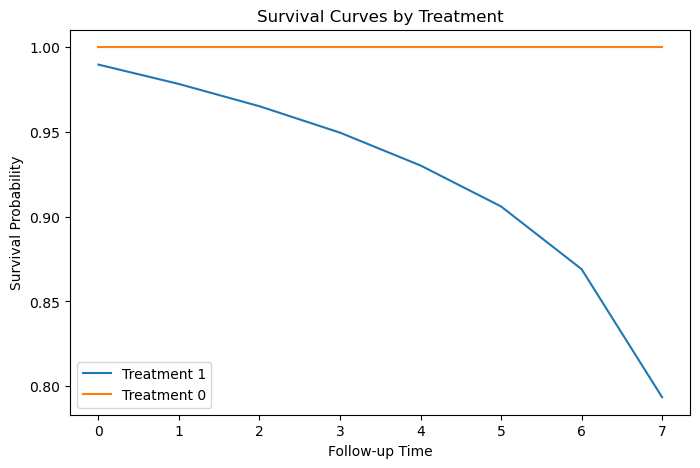

In [155]:
def estimate_survival(data, time_col, event_col, group_col):
    kmf = KaplanMeierFitter()
    survival_curves = {}
    
    for group in data[group_col].unique():
        group_data = data[data[group_col] == group]
        kmf.fit(group_data[time_col], event_observed=group_data[event_col], label=str(group))
        survival_curves[group] = kmf.survival_function_
    
    return survival_curves

# Compute survival estimates for ITT model
survival_curves = estimate_survival(trial_itt_loaded, time_col="followup_time", event_col="outcome", group_col="treatment")

plt.figure(figsize=(8, 5))
for group, curve in survival_curves.items():
    plt.plot(curve.index, curve, label=f"Treatment {group}")

plt.xlabel("Follow-up Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves by Treatment")
plt.legend()
plt.show()
